In [ ]:
# default_exp data.covariates

In [14]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

[autoreload of prompt_toolkit.cache failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'SimpleCache' object layout differs from 'SimpleCache'
]
[autoreload of prompt_toolkit.filters.cli failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of prompt_toolkit.layout.containers failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a code object with 1 

In [16]:
! pip install 'tokenizers==0.9.3'
#! pip install 'transformers==3.5.0'

# Covariate Analysis and Feature Engineering 
>
>@danaderp 11.17.20 .
>

In [142]:
#export
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats as st
import os
import time

In [18]:
#export
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [19]:
#export
import functools 
from operator import or_
from collections import Counter
import datetime

In [55]:
#export
#import sentencepiece as spm
import pickle
from pathlib import Path
from tokenizers import Tokenizer, models

In [21]:
#export
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [22]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Fixing parameters

In [23]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'tb_01':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl',
        'tb_02':dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy.jsonl',
        'output': dvc_path / 'nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/'
    }

In [24]:
params = params()

In [25]:
params['output'] / 'xxx.jsonl'

PosixPath('../dvc-icodegen/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/xxx.jsonl')

In [26]:
#tst
logging.info( params['tokenizer'] )

2021-06-30 14:53:25,923 : INFO : ../dvc-icodegen/models/bpe/tokenizer-java-v1.json


In [27]:
df_error_tax = pd.read_json(
            params['tb_01'], orient="records", lines=True)

2021-06-30 14:53:28,371 : INFO : Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2021-06-30 14:53:28,372 : INFO : Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-30 14:53:28,373 : INFO : NumExpr defaulting to 8 threads.


In [30]:
df_error_tax.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,code,x_treatment
0,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,False
1,0.0027,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0003,0.0000,0.0008,<private> <void> success<(>io.netty.channel.Ch...,True
2,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,False
3,0.0027,0.0,0.0001,0.0,0.0001,0.0001,0.0,0.0002,0.0000,0.0012,<private> <void> handleConnectRequest<(>com.as...,True
4,0.0018,0.0,0.0002,0.0,0.0001,0.0000,0.0,0.0006,0.0004,0.0009,<@>java.lang.Override<n><protected> <void> onS...,False


In [28]:
df_cross = pd.read_json(
        params['tb_02'], orient="records", lines=True)

In [105]:
df_cross.head()

,code,y_cross_entropy,x_treatment
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False


# First Covariate Analysis: Token Size

In [ ]:
#Upload tokenizers here
#Use Tokenizer recent version
#Load tokenizer
#Update files (for one time) the main json files to add the column of tokenizers
#Count the tokens per method
#Visualize the most popular tokens (and less popular)

In [83]:
#export
class TokenizeHF():
    def __init__( self, no_padding = True, no_truncation = True ):
        """
        :param method: Code snippet (plain text)
        :returns: Encoded result using the provided tokenizer
        """
        #Load tokenizer
        self.tokenizer = Tokenizer.from_file( str( params['tokenizer'] ) )
        if no_padding:
            self.tokenizer.no_padding()
        if no_truncation:
            self.tokenizer.no_truncation()
        pass
    
    #@staticmethod
    def tokenizeHF(self, method ):
        output = {}
        # encode method and then convert to format that hf models expect
        encoding = self.tokenizer.encode( #Tokenize a Seq
            "<sos>" + method
        )
        """
        This source code is for further analysis
        output["input_ids"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.ids, dtype=tf.int32), 0
        )
        output["attention_mask"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.attention_mask, dtype=tf.int32), 0
        )"""
        return encoding
    
    #@staticmethod
    def decodingHF( self, idss ):
        return self.tokenizer.decode( idss , skip_special_tokens=False )
        #return self.tokenizer.convert_ids_to_tokens(idss )

In [39]:
code = df_cross['code']

In [40]:
code[0]

'<private> <void> success<(>io.netty.channel.Channel channel<)> <{><n>    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug<(>"success info <return> <for>m MySQLHandshakeHandler"<)><;><n>    io.netty.buffer.ByteBuf out <=> channel.alloc<(><)>.buffer<(><)><;><n>    org.mycat.netty.mysql.OK ok <=> <new> org.mycat.netty.mysql.OK<(><)><;><n>    ok.sequenceId <=> 2<;><n>    ok.setStatusFlag<(>Flags.SERVER_STATUS_AUTOCOMMIT<)><;><n>    out.writeBytes<(>ok.toPacket<(><)><)><;><n>    channel.writeAndFlush<(>out<)><;><n><}>'

In [84]:
class_tokenize = TokenizeHF() 

In [85]:
input_ids = class_tokenize.tokenizeHF( method = 'this is a text <private> <void> success<(>io.netty' )

In [86]:
input_ids.ids

[1, 360, 492, 388, 1634, 189, 35, 189, 50, 3905, 83, 1702, 105, 3342, 487]

In [200]:
input_ids.tokens

['<sos>',
 '<private>',
 'Ġ',
 '<void>',
 'Ġhandle',
 'Connect',
 'Request',
 '<(>',
 'com',
 '.',
 'ass',
 'istant',
 '.',
 'connection',
 '.',
 'Connection',
 'Manager',
 '.',
 'Connect',
 'Request',
 'Ġrequest',
 '<)>',
 'Ġ',
 '<{>',
 '<n>',
 'ĠĠĠ',
 'Ġcom',
 '.',
 'ass',
 'istant',
 '.',
 'utils',
 '.',
 'Log',
 '.',
 'd',
 '<(>',
 'com',
 '.',
 'ass',
 'istant',
 '.',
 'connection',
 '.',
 'Connection',
 'Manager',
 '.',
 'TAG',
 ',',
 'Ġ',
 '<(>',
 '"',
 'handle',
 'Connect',
 'Request',
 ',',
 'Ġrequest',
 '<:>',
 '"',
 'Ġ',
 '<+>',
 'Ġrequest',
 '<)>',
 '<)>',
 '<;>',
 '<n>',
 'ĠĠĠĠ',
 '<if>',
 'Ġ',
 '<(>',
 'm',
 'Stop',
 'ped',
 '<)>',
 'Ġ',
 '<{>',
 '<n>',
 'ĠĠĠĠĠĠĠ',
 'Ġcom',
 '.',
 'ass',
 'istant',
 '.',
 'utils',
 '.',
 'Log',
 '.',
 'd',
 '<(>',
 'com',
 '.',
 'ass',
 'istant',
 '.',
 'connection',
 '.',
 'Connection',
 'Manager',
 '.',
 'TAG',
 ',',
 'Ġ"',
 'handle',
 'Connect',
 'Request',
 ',',
 'Ġm',
 'Stop',
 'ped',
 'Ġis',
 'Ġ',
 '<true>',
 '"',
 '<)>',
 '<;>',
 '

In [91]:
input_ids = class_tokenize.tokenizeHF( method = code[0] )
#input_ids = input_ids['input_ids']
logging.info(input_ids)
#logging.info(input_ids.num_tokens)
logging.info(input_ids.ids)
logging.info(len(input_ids.ids))
logging.info(input_ids.tokens)

2021-06-30 15:56:46,797 : INFO : Encoding(num_tokens=177, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
2021-06-30 15:56:46,797 : INFO : [1, 35, 189, 50, 3905, 83, 1702, 105, 3342, 487, 105, 2867, 105, 1821, 2647, 84, 189, 79, 91, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 136, 180, 2298, 3943, 5731, 1072, 105, 1926, 105, 1025, 83, 93, 6150, 2399, 189, 38, 189, 23, 168, 464, 180, 2298, 3943, 5731, 1072, 93, 84, 85, 91, 195, 3644, 105, 3342, 487, 105, 2057, 105, 881, 3453, 1062, 189, 53, 2647, 105, 212, 2586, 83, 84, 105, 2057, 83, 84, 85, 91, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 4959, 189, 53, 189, 33, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 83, 84, 85, 91, 195, 4959, 105, 6909, 406, 189, 53, 883, 85, 91, 195, 4959, 105, 7941, 4880, 83, 4661, 105, 5872, 154, 5014, 154, 4723, 138, 9003, 84, 85, 91, 195, 1062, 105, 967, 1305, 83, 1649, 105, 

In [104]:
class_tokenize.decodingHF( input_ids.ids )

'<sos><private> <void> handleConnectRequest<(>com.assistant.connection.ConnectionManager.ConnectRequest request<)> <{><n>    com.assistant.utils.Log.d<(>com.assistant.connection.ConnectionManager.TAG, <(>"handleConnectRequest, request<:>" <+> request<)><)><;><n>    <if> <(>mStopped<)> <{><n>        com.assistant.utils.Log.d<(>com.assistant.connection.ConnectionManager.TAG, "handleConnectRequest, mStopped is <true>"<)><;><n>        removeConnectRequest<(>request.connId<)><;><n>        not<if>yConnectionCreationResult<(><null>, request.listener, <true>, Connection.CONNECTION_REASON_CODE_CONNECT_REQUEST_CANCELED<)><;><n>        <return> <;><n>    <}><n>    connectToInternal<(>request.ipAddress, request.port, request.listener, request<)><;><n><}>'

### Generating the covariate column in the dataset
- For bootstrapping please follow [link](https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d)
- For confidence intervals follow [link](https://www.statology.org/confidence-intervals-python/)

In [106]:
#export
def method_size( method, class_tkz ):
    '''Return the size of the tokens for a give method based on id'''
    input_ids = class_tkz.tokenizeHF( method = method )
    return len(input_ids.ids)

In [107]:
z_count_subwords = [method_size( class_tkz = class_tokenize, method = mtd )  for mtd in df_cross['code'].values] #using df_cross

In [109]:
#Attaching new column
df_error_tax['z_count_subwords'] = z_count_subwords
df_cross['z_count_subwords'] = z_count_subwords

In [110]:
df_error_tax.to_json(params['output'] / 'bug_fix_error_taxonomy_z_v1.jsonl', orient="records", lines=True)
df_cross.to_json(params['output'] / 'bug_fix_cross_entropy_z_v1.jsonl', orient="records", lines=True)

In [160]:
#export
def bootstrapping( np_data, np_func, size):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range(size) ]
    
    logging.info("Empirical Mean: " + str(np.mean(np_data))) #Empirical Mean
    logging.info( "Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return pd.DataFrame(bootstrap_repl, columns = ['bootstrap_repl'])

In [161]:
np_data = [2,3,4,5,6,7,8,0]
np_boots = bootstrapping( np_data, np.mean, 100)

2021-06-30 17:50:24,875 : INFO : Empirical Mean: 4.375
2021-06-30 17:50:24,875 : INFO : Bootstrapped Mean: 4.39875


In [162]:
st.sem(np_data)

0.9437293044088436

In [163]:
#export
def confidence_intervals(np_data, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = st.norm.interval(alpha=conf, loc = np.mean( np_data ), scale = st.sem(np_data))
    logging.info( CI )
    return CI

In [164]:
confidence_intervals(np_boots.bootstrap_repl.values)
confidence_intervals(np_boots,conf=0.99)

2021-06-30 17:50:27,122 : INFO : (4.236137858789555, 4.561362141210444)
2021-06-30 17:50:27,124 : INFO : (array([4.18504142]), array([4.61245858]))


(array([4.18504142]), array([4.61245858]))

## Descriptive Statistics for first covariate (z_count_subwords)

In [111]:
df_cross.head()

,code,y_cross_entropy,x_treatment,z_count_subwords
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False,177
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True,177
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False,195
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True,195
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False,121


In [122]:
df_cross.describe()

,y_cross_entropy,z_count_subwords
count,129444.000000,129444.000000
mean,6.142502,185.407628
std,1.510858,64.357274
min,2.066005,68.000000
25%,5.038853,143.000000
50%,5.982966,176.000000
75%,7.085069,216.000000
max,12.283474,4465.000000


### Correlation Analysis 

In [194]:
LIM = 500
S = 2

In [176]:
df_buggy = df_cross.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy = df_cross.loc[lambda row: row['x_treatment'] == False  ].copy()

<AxesSubplot:xlabel='z_count_subwords', ylabel='y_cross_entropy'>

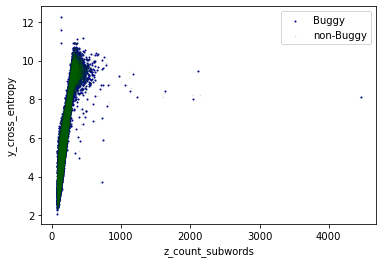

In [192]:
ax = df_buggy.plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="DarkBlue", label="Buggy")
df_nonbuggy.plot.scatter(x="z_count_subwords", y="y_cross_entropy", s= S,color="DarkGreen", label="non-Buggy", alpha=0.1, ax=ax)

In [181]:
#General Correlation
np.corrcoef(df_cross.y_cross_entropy.values, df_cross.z_count_subwords.values)

array([[1.        , 0.86976626],
       [0.86976626, 1.        ]])

In [182]:
#Buggy Correlation
np.corrcoef(df_buggy.y_cross_entropy.values, df_buggy.z_count_subwords.values)

array([[1.        , 0.87261563],
       [0.87261563, 1.        ]])

In [183]:
#NonBuggy Correlation
np.corrcoef(df_nonbuggy.y_cross_entropy.values, df_nonbuggy.z_count_subwords.values)

array([[1.        , 0.86695886],
       [0.86695886, 1.        ]])

<AxesSubplot:title={'center':'z_count_subwords'}, xlabel='[x_treatment]'>

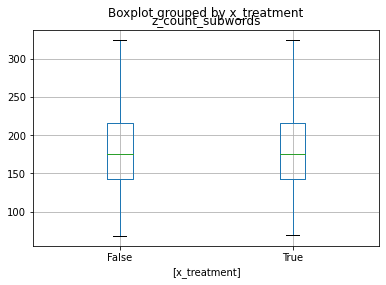

In [199]:
#first covariate by treatment
df_cross[['z_count_subwords','x_treatment']].boxplot( 
    by='x_treatment',
    showfliers=False,
)

<AxesSubplot:xlabel='z_count_subwords', ylabel='y_cross_entropy'>

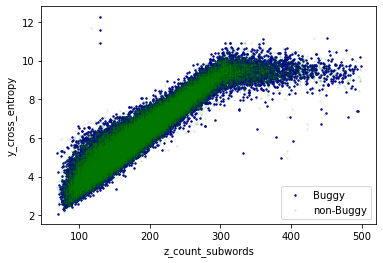

In [195]:
ax = df_buggy.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="DarkBlue", label="Buggy")
df_nonbuggy.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="Green", label="non-Buggy", alpha=0.1, ax=ax)

In [121]:
df_cross['z_count_subwords'].loc[lambda row: row < LIM ]

0         177
1         177
2         195
3         195
4         121
         ... 
129439    196
129440    199
129441    195
129442    140
129443    142
Name: z_count_subwords, Length: 96787, dtype: int64

### Bootstrapping of Means

In [165]:
bs_cross = bootstrapping( df_cross.z_count_subwords.values , np.mean, 500)

2021-06-30 17:50:47,288 : INFO : Empirical Mean: 185.4076280090232
2021-06-30 17:50:47,289 : INFO : Bootstrapped Mean: 185.40690630697446


In [166]:
confidence_intervals( bs_cross.bootstrap_repl.values )

2021-06-30 17:50:50,405 : INFO : (185.3915753578344, 185.42223725611453)


(185.3915753578344, 185.42223725611453)

<AxesSubplot:ylabel='Frequency'>

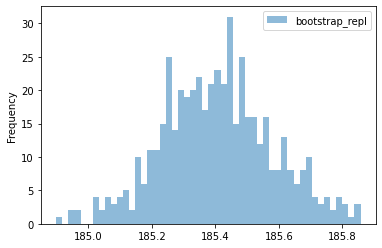

In [167]:
bs_cross.plot.hist(alpha=0.5, bins=50)

### Empirical PDF and CDF

<AxesSubplot:ylabel='Frequency'>

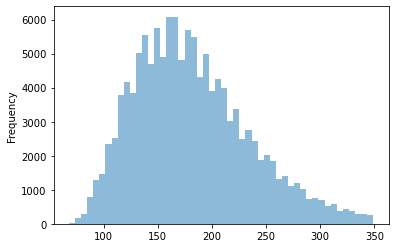

In [127]:
# Empirical PDF or Probability Density Function
df_cross['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist(alpha=0.5, bins=50)

<AxesSubplot:ylabel='Density'>

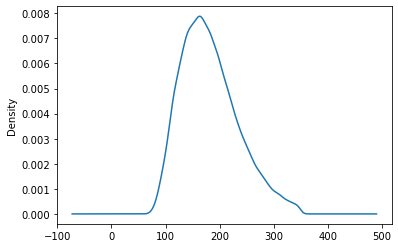

In [128]:
# PDF or Probability Density Function
df_cross['z_count_subwords'].loc[lambda row: row < LIM ].plot.kde()

<AxesSubplot:ylabel='Frequency'>

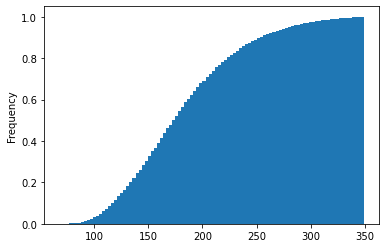

In [131]:
#Empirical CDF demonstrate that 50% of methods in our sample have around 180 or less tokens. 
df_cross['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist( 
    cumulative = True,
    density =1,
    bins=100
)

# Second Covariate Analysis: SE Metrics
> This module provides a tool for computing metrics (from static analysis) for python source code using Using <a href="https://github.com/mauricioaniche/ck">CK Package</a>

CK is a java package (jar) which is going to be executed from terminal. It requires the code which is going to be analyzed to be located at <i>physical</i> files. For that reason, the dataset is going to be used to produce some <i>.java</i> files.

Each record, corresponds to a individual class. When working with method-level snippets, "articial" classes are created for performing the analysis.

In [ ]:
# export
def write_dataset_to_files(df_series, destination_path):
    """
    Function to generate .java files.
    
    Params:
    # df_series: Pandas Series (DataFrame column) with the source code records.
    # destination_path: (str) Absolute path to be used as directory for the generated files.
    
    Returns:
    
    Collection of paths for the corresponding java files.
    
    """
    java_template = 'public class <class_name>{\n    <code_snippet>\n}'
    
    if not os.path.exists(destination_path):
        logging.info('Creating directory.')
        os.mkdir(destination_path)
    
    logging.info("Generating physical .java files.")
    
    file_paths = []
    for idx, value in df_series.iteritems():
        class_name = f'ClassRecord{idx}'
        code = java_template.replace('<class_name>', class_name)
        code = code.replace('<code_snippet>', value)
        file_path = f'{destination_path}/{class_name}.java'
        with open(file_path, 'w') as file:
            file.write(code)
            file_paths.append(file_path)
            
    return file_paths

In [ ]:
# export

def jarWrapper(*args):
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [ ]:
# export

class JavaAnalyzer():
    """
    Class get metrics f
    """
    def __init__(self, ck_jar_path):
        self.ck_jar_path = ck_jar_path
    
    def compute_metrics(self, df_series, files_destination_path):
        """
        Computes metrics for a pandas series of java source code snippets
        
        Params
        # df_series: Pandas series (df column) containing java source snippets
        # files_destination_path: Path indicating where the physical .java files are going to be created (for metrics computation)
        
        Returns:
        
        Pandas Dataframe containing metrics
        
        """
        file_paths = write_dataset_to_files(df_series, files_destination_path)
        self.__call_ck_package(files_destination_path)
        metrics_df = self.__get_metrics_df()
        self.__remove_csv_files()
        self.__remove_tmp_java_files(file_paths)
        
        return metrics_df
        
    def __call_ck_package(self, files_path):
        """
        Performs call to external .jar package.
        """
        args = [self.ck_jar_path, files_path, 'false', '0', 'True']
        result = jarWrapper(*args)
        logging.info(f'CK package produced this output:\n{result}')
        
    def __get_metrics_df(self):
        """
        Reads report files (csv) generated by the CK package.
        
        Returns:
        
        Pandas Dataframe containing appropriate metrics
        """
        class_metrics_df = pd.read_csv('class.csv')
        # method_metrics_df = pd.read_csv('method.csv')

        # merged_df = pd.merge(left = class_metrics_df, right = method_metrics_df, left_on='file', right_on='file')

        appropriate_columns = ['file','class', 'wmc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty',
                          'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty','synchronizedMethodsQty',
                          'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
                          'defaultFieldsQty', 'visibleFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty',
                          'nosi', 'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
                          'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty',
                          'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'uniqueWordsQty', 'modifiers']

        class_metrics_df = class_metrics_df[appropriate_columns]

        return class_metrics_df
    
    def __remove_csv_files(self):
        """
        Removes files generated by CK package.
        """
        if os.path.exists('class.csv'):
            os.remove('class.csv')
        if os.path.exists('method.csv'):
            os.remove('method.csv')
        if os.path.exists('field.csv'):
            os.remove('field.csv')
            
    def __remove_tmp_java_files(self, paths):
        """
        Removes the temporary generated java files.
        """
        for file_path in paths:
            os.remove(file_path)

In [ ]:
# General parameters for testing

def get_default_params():
    return {
    'ck_jar_path': 'ck_metrics_tool/ck-metrics.jar',
    'search_net_ds_path': '/tf/main/dvc-ds4se/code/searchnet/clean_java.csv',
    'sampling_size': 100,
    'physical_files_path': '/tf/main/nbs/test_data/test_metrics'
}

# Descriptive Statistics

All Java Set

In [ ]:
java_df.describe()

,code_len,bpe32_len
count,467203.000000,467203.000000
mean,113.079653,146.274557
std,189.121245,303.804009
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,150.000000
max,27192.000000,52975.000000


All Java Partition

In [ ]:
df_train.describe()

,code_len,bpe32_len
count,384868.000000,384868.000000
mean,113.720826,147.151002
std,194.007951,313.904001
min,20.000000,20.000000
25%,42.000000,50.000000
50%,67.000000,81.000000
75%,122.000000,151.000000
max,27192.000000,52975.000000


In [ ]:
logging.info([ p.describe() for p in list_all_partitions])

2020-11-17 12:31:54,629 : INFO : [            code_len      bpe32_len
count  384868.000000  384868.000000
mean      113.720826     147.151002
std       194.007951     313.904001
min        20.000000      20.000000
25%        42.000000      50.000000
50%        67.000000      81.000000
75%       122.000000     151.000000
max     27192.000000   52975.000000,            code_len     bpe32_len
count  14605.000000  14605.000000
mean      94.331736    120.097843
std      115.802231    171.079255
min       21.000000     21.000000
25%       39.000000     46.000000
50%       59.000000     71.000000
75%      104.000000    127.000000
max     3099.000000   5747.000000,            code_len     bpe32_len
count  25011.000000  25011.000000
mean     114.274599    148.204710
std      166.432695    245.938732
min       21.000000     22.000000
25%       43.000000     52.000000
50%       69.000000     84.000000
75%      125.000000    155.000000
max     5685.000000  10015.000000,            code_len     bpe

In [ ]:
logging.info([ stats.median_absolute_deviation(p['code_len'].values) for p in list_all_partitions])

2020-11-17 12:29:30,408 : INFO : [45.9606, 37.065, 47.4432, 44.477999999999994]


Train Partition

In [ ]:
# Frequent Characters
train_tokens = df_train.code_tokens.values

In [ ]:
train_vocab_tokens = [ eval(method)  for method in train_tokens ] #Evaluating given tokens

In [ ]:
train_counter_tokens = [ Counter(method) for method in train_vocab_tokens ] #Counting the words

In [ ]:
train_counter = functools.reduce(lambda a,b : a+b, train_counter_tokens ) ## [Warning! Time Consuming]

In [ ]:
train_counter

NameError: name 'train_counter' is not defined

In [ ]:
#Persisting the counter object
with open(params['eda']+'['+ str(datetime.datetime.now()) +']-codesearchnet_token_counts.pickle', 'wb') as outputfile:
    pickle.dump( train_counter, outputfile )